In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import components.models as models
import components.models2 as models2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision

## Autoencoders

In [4]:
# ae = models.Autoencoder(5)
# ae

In [5]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

# def train(autoencoder, data, epochs=20):
#     opt = torch.optim.Adam(autoencoder.parameters())
#     for epoch in range(epochs):
#         for x, y in data:
#             x = x.to(device) # GPU
#             opt.zero_grad()
#             x_hat = autoencoder(x)
#             loss = ((x - x_hat)**2).sum()
#             loss.backward()
#             opt.step()
#     return autoencoder

In [6]:
# autoencoder = train(autoencoder, data)

In [28]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z, mu, sigma = autoencoder.Encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10',alpha=0.7)
        if i > num_batches:
            plt.colorbar()
            break

In [8]:
# plot_latent(autoencoder, data)

In [9]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.Decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [10]:
# plot_reconstructed(autoencoder)

## Variational Autoencoders

In [11]:
# vae = models.VariationalAutoencoder(5)
# vae

input_size = 784
hidden_sizes = [512,256,128,2]

vae = models2.VariationalAutoencoder(input_size, hidden_sizes)

In [31]:
def train(autoencoder, data, epochs=40):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            
            # forward pass
            x_hat, mu, sigma = autoencoder(x)
            
            # calculate loss
            # KL divergence of N(mu,sigma) from N(0,1)
            # consider adding burn-in counter for KL
            kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1/2).sum() 
            
            #kl_loss = 0.5 * (torch.exp(z_var) + z_mu**2 - z_var - 1.).sum()
            
            # difference of predictions
            mse = ((x - x_hat)**2).sum()
            loss = mse + kl
            total_loss += loss
            
            loss.backward()
            opt.step()
        print(f'epoch {epoch} loss:{total_loss / len(data)}')
    return autoencoder

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

autoencoder = vae.to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=False),
        batch_size=128,
        shuffle=True)


cpu


In [ ]:
%%time
# 6 min with BN for 20 epochs

vae = train(vae, data)

epoch 0 loss:6381.02099609375
epoch 1 loss:6385.40576171875


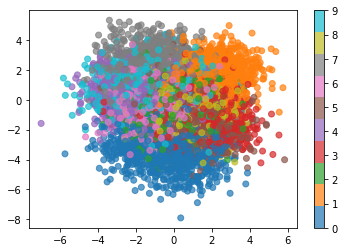

In [29]:
plot_latent(vae, data) # after 20 epochs

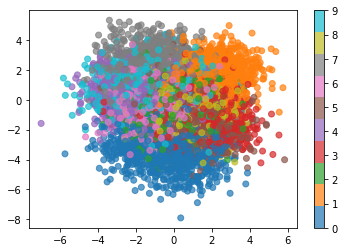

In [29]:
plot_latent(vae, data) # after 40 epochs

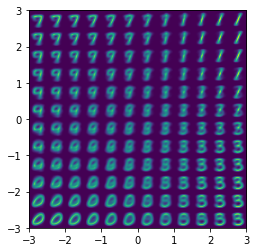

In [27]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

## VAE source 2
https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

In [ ]:
# def kl_divergence(self, z, mu, std):
#     # --------------------------
#     # Monte carlo KL divergence
#     # --------------------------
#     # 1. define the first two probabilities (in this case Normal for both)
#     p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
#     q = torch.distributions.Normal(mu, std)

#     # 2. get the probabilities from the equation
#     log_qzx = q.log_prob(z)
#     log_pz = p.log_prob(z)

#     # kl
#     kl = (log_qzx - log_pz)
#     kl = kl.sum(-1)
#     return kl

In [ ]:
# def gaussian_likelihood(self, x_hat, logscale, x):
#     scale = torch.exp(logscale)
#     mean = x_hat
#     dist = torch.distributions.Normal(mean, scale)

#     # measure prob of seeing image under p(x|z)
#     log_pxz = dist.log_prob(x)
#     return log_pxz.sum(dim=(1, 2, 3))

In [33]:
# class VAE(nn.Module):
#     def __init__(self, enc_out_dim, latent_dim):
#         super(VAE, self).__init__()
        
#         # self.encoder
#         # self.decoder
    
#         # distribution parameters
#         self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
#         self.fc_var = nn.Linear(enc_out_dim, latent_dim)
        
#         # for the gaussian likelihood
#         self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
#     def training_step(self, batch, batch_idx):
#         x, _ = batch

#         # encode x to get the mu and variance parameters
#         x_encoded = self.encoder(x)
#         mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

#         # sample z from q
#         std = torch.exp(log_var / 2)
#         q = torch.distributions.Normal(mu, std)
#         z = q.rsample()

#         # decoded
#         x_hat = self.decoder(z)

#         # reconstruction loss
#         recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

#         # kl
#         kl = self.kl_divergence(z, mu, std)

#         # elbo
#         elbo = (kl - recon_loss)
#         elbo = elbo.mean()

#         self.log_dict({
#             'elbo': elbo,
#             'kl': kl.mean(),
#             'recon_loss': recon_loss.mean(),
#             'reconstruction': recon_loss.mean(),
#             'kl': kl.mean(),
#         })

#         return elbo

### VAE from paper
Design of metalloproteins and
novel protein folds using variational
autoencoders



In [ ]:
# mlp = models2.MLP(sizes=[512, 256, 128, 16])
# mlp

In [ ]:

# input_size=16
# hidden_sizes=[128,256,512]
# output_size=1024

# dec2 = models2.Decoder(input_size, hidden_sizes, output_size)
# dec2

In [ ]:
# input_size=1024
# hidden_sizes=[512,256,128]
# output_size=16

# enc2 = models2.Encoder(input_size, hidden_sizes, output_size)
# enc2

In [ ]:
# input_size=1024
# hidden_sizes=[512,256,128,16]

# vae = models2.VariationalAutoencoder(input_size, hidden_sizes)
# vae